**<span style="color: #808080;">In The Name of God</span>**

---

**<span style="color: #808080;">Mani hosseini</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102552</span>**<br>
**<span style="color: #808080;">Parsa Bukani</span>** <br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102501</span>**<br>
**<span style="color: #808080;">Erfan Falahati</span>**<br>
**<span style="color: #808080;">SID:</span> <span style="color: #808080;">810102491</span>**


# <span style="color:#009e60;">**CNN**
</span>



## <span style="color: #009E60;">**Dataset Loading:**

### <span style="color: #009E60;">**Downloading from kaggle:**

In [2]:
import kagglehub
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# path=kagglehub.dataset_download("alsaniipe/flowers-multiclass-datasets")
# print("Path to dataset files:", path)


dataset was already divided so we just load it.

## <span style="color: #009E60;">**Image Preprocessing:**

### <span style="color: #009E60;">**Load images:**

In [9]:


CONTENT=os.path.join("content","flower_photos")
train_path= os.path.join(CONTENT,"train")
test_path= os.path.join(CONTENT,"test")
val_path= os.path.join(CONTENT,"validation")
datagen = ImageDataGenerator(
    rescale=1./255,
)
class_mode='sparse'


train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

train_generator_sparse = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_generator_sparse = datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_generator_sparse = datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)



print("shape of the image batch:")
images, labels = next(test_generator)
print(images.shape)
print(labels.shape)
print("classes:")
print(train_generator.class_indices)



Found 3540 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 3540 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
shape of the image batch:
(32, 224, 224, 3)
(32, 5)
classes:
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


### <span style="color: #009E60;">**Visualizing a few images:**

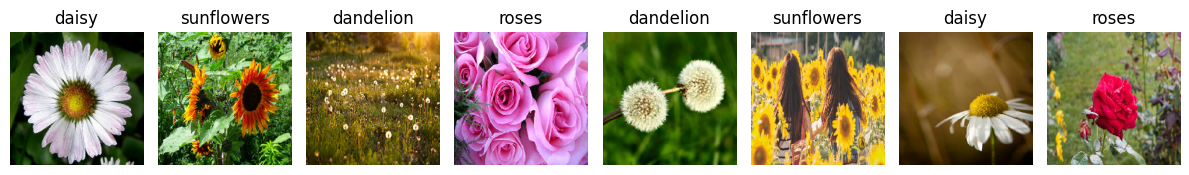

In [ ]:

images, labels = next(train_generator)

label_indices = np.argmax(labels, axis=1)

class_names = list(train_generator.class_indices.keys())


plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[label_indices[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()



## <span style="color: #009E60;">**Data Augmentation:**

In [ ]:



data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=42)
])




## <span style="color: #009E60;">**VGG:**


### <span style="color: #009E60;">**Describe & Complie Model:**

In [ ]:
from functools import partial
import tensorflow as tf

tf.random.set_seed(42)

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")


vgg_model = tf.keras.Sequential([
    data_augmentation,

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation="softmax")
])

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)




if tf.test.is_gpu_available():
    print("GPU is being used!")
    print("GPU Device:", tf.test.gpu_device_name())
else:
    print("GPU not found. Using CPU.")



GPU is being used!
GPU Device: /device:GPU:0


### <span style="color: #009E60;">**Fit Model:**

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 54s 488ms/step - accuracy: 0.2879 - loss: 1.5812 - val_accuracy: 0.2875 - val_loss: 1.4865
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 461ms/step - accuracy: 0.3512 - loss: 1.4878 - val_accuracy: 0.3750 - val_loss: 1.4118
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 468ms/step - accuracy: 0.3983 - loss: 1.3944 - val_accuracy: 0.5875 - val_loss: 1.1260
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 476ms/step - accuracy: 0.4913 - loss: 1.2012 - val_accuracy: 0.6375 - val_loss: 0.9902
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - accuracy: 0.5383 - loss: 1.1302 - val_accuracy: 0.6250 - val_loss: 0.9382
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 461ms/step - accuracy: 0.5813 - loss: 1.0654 - val_accuracy: 0.7000 - val_loss: 0.8337
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 466ms/step - accuracy: 0.6168 - loss: 1.0239 - val_accuracy: 0.4250 - val_loss: 1.2081
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 477ms/step - accuracy: 0.5918 - loss: 1

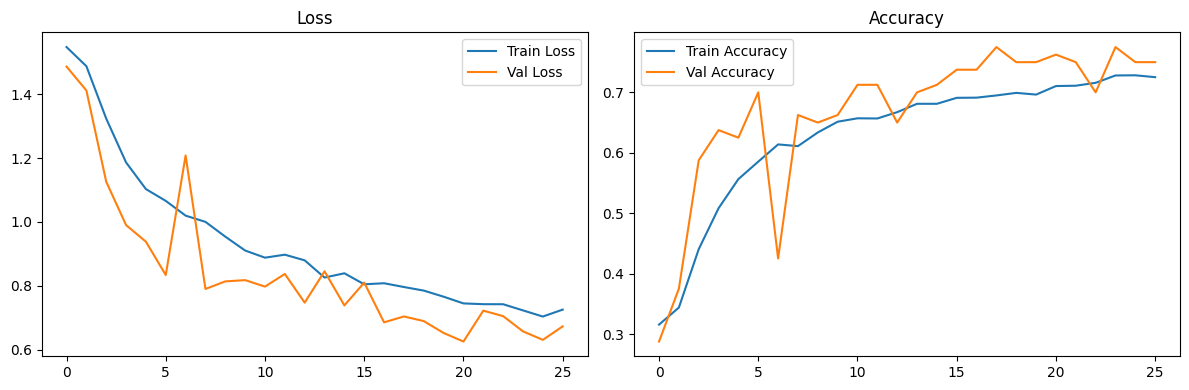

In [ ]:




early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping]
)
vgg_model.save('vgg_flower_classifier.h5')



def plot_training(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training(history)

### <span style="color: #009E60;">**Label Encoding:**

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 57s 496ms/step - accuracy: 0.2554 - loss: 1.8862 - val_accuracy: 0.2875 - val_loss: 1.5652
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 471ms/step - accuracy: 0.4028 - loss: 1.4102 - val_accuracy: 0.3500 - val_loss: 1.3173
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 473ms/step - accuracy: 0.4547 - loss: 1.2467 - val_accuracy: 0.5875 - val_loss: 0.9811
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 468ms/step - accuracy: 0.5304 - loss: 1.1710 - val_accuracy: 0.4000 - val_loss: 1.2973
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 468ms/step - accuracy: 0.5525 - loss: 1.1143 - val_accuracy: 0.5625 - val_loss: 0.9223
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 474ms/step - accuracy: 0.5664 - loss: 1.0689 - val_accuracy: 0.5500 - val_loss: 1.0826
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 477ms/step - accuracy: 0.5897 - loss: 1.0244 - val_accuracy: 0.6375 - val_loss: 0.9085
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 464ms/step - accuracy: 0.6361 - loss: 0

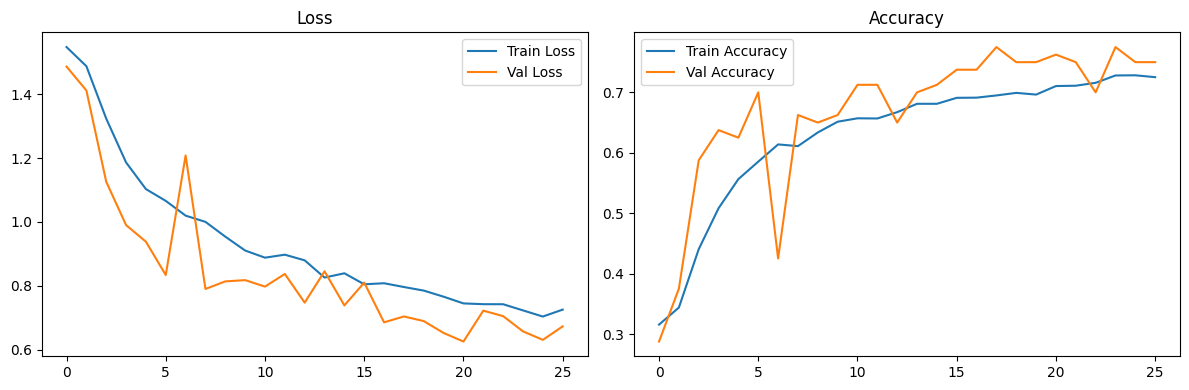

In [ ]:

vgg_model_sparse=tf.keras.Sequential([
    data_augmentation,

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    tf.keras.layers.MaxPool2D(),

    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2048, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation="softmax")
])
vgg_model_sparse.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

history_sparse = vgg_model_sparse.fit(
    train_generator_sparse,
    validation_data=val_generator_sparse,
    epochs=30,
    callbacks=[early_stopping]
)
vgg_model_sparse.save('vgg_flower_classifier_sparse.h5')
plot_training(history)


### <span style="color: #009E60;">**Evaluation:**

In [ ]:
print("\n ==========One Hot Encoding==========")
loaded_model = load_model('vgg_flower_classifier.h5')

test_loss, test_acc = loaded_model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc:.4f}")

test_images, test_labels = next(test_generator)
predictions = loaded_model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)


print("\n ==========Label Encoding==========")

loaded_model = load_model('vgg_flower_classifier_sparse.h5')

test_loss, test_acc = loaded_model.evaluate(test_generator_sparse)
print(f"\nTest accuracy: {test_acc:.4f}")

test_images, test_labels = next(test_generator_sparse)
predictions = loaded_model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels

cm = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(cm)


 ==========One Hot Encoding==========


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.7167 - loss: 0.7087

Test accuracy: 0.7000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step

Confusion Matrix:
[[5 0 0 0 0]
 [1 6 0 1 0]
 [1 0 1 2 2]
 [0 0 0 6 0]
 [2 0 1 1 3]]

 ==========Label Encoding==========


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6587 - loss: 0.8005

Test accuracy: 0.6600


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step

Confusion Matrix:
[[5 0 0 0 0]
 [0 2 0 1 0]
 [2 0 0 0 1]
 [0 0 0 6 0]
 [0 0 0 1 0]]



## <span style="color: #009E60;">**ResNet50:**

### <span style="color: #009E60;">**Setup:**

In [9]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### <span style="color: #009E60;">**Freeze Base,Train Head:**

In [11]:

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

print("Training only the top layers")
history1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


model.save("resnet_stage1.h5")


Training only the top layers
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.2476 - loss: 1.8111 - val_accuracy: 0.4125 - val_loss: 1.4765
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.2935 - loss: 1.5989 - val_accuracy: 0.4000 - val_loss: 1.4473
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.3455 - loss: 1.5266 - val_accuracy: 0.4000 - val_loss: 1.4153
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.3917 - loss: 1.4782 - val_accuracy: 0.4500 - val_loss: 1.4039
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.3828 - loss: 1.4621 - val_accuracy: 0.4500 - val_loss: 1.3850
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.3989 - loss: 1.4421 - val_accuracy: 0.4375 - val_loss: 1.3939
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.4206 - loss: 1.4236 - val_accuracy: 0.4125 - val_loss: 1.3703
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step

### <span style="color: #009E60;">**Unfreeze  Last  Conv  Layer:**

In [12]:

print("\nUnfreezing last conv block")
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


model.save("resnet_stage2.h5")




Unfreezing last conv block
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 43s 220ms/step - accuracy: 0.4278 - loss: 1.4621 - val_accuracy: 0.2625 - val_loss: 2.0274
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - accuracy: 0.5915 - loss: 1.0564 - val_accuracy: 0.2875 - val_loss: 1.9758
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.6491 - loss: 0.9272 - val_accuracy: 0.4250 - val_loss: 1.4254
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.6885 - loss: 0.8304 - val_accuracy: 0.5250 - val_loss: 1.3809
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.7271 - loss: 0.7442 - val_accuracy: 0.6500 - val_loss: 0.9439
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.7567 - loss: 0.6619 - val_accuracy: 0.4875 - val_loss: 1.8546
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.7518 - loss: 0.6679 - val_accuracy: 0.5125 - val_loss: 1.7161
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step 

### <span style="color: #009E60;">**Unfreeze All:**

In [14]:

print("Unfreezing all layers")
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=val_generator,
    # validation_steps=val_generator.samples // 32,
    callbacks=[early_stopping]
)

model.save("resnet_stage3_final.h5")


Unfreezing all layers
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 113s 525ms/step - accuracy: 0.8273 - loss: 0.4733 - val_accuracy: 0.2000 - val_loss: 2.1396
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.9204 - loss: 0.2370 - val_accuracy: 0.2875 - val_loss: 1.9249
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.9601 - loss: 0.1323 - val_accuracy: 0.4125 - val_loss: 1.6994
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - accuracy: 0.9828 - loss: 0.0790 - val_accuracy: 0.5625 - val_loss: 1.5832
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 289ms/step - accuracy: 0.9844 - loss: 0.0579 - val_accuracy: 0.6625 - val_loss: 1.1001
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.9904 - loss: 0.0444 - val_accuracy: 0.8000 - val_loss: 0.7251
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - accuracy: 0.9979 - loss: 0.0211 - val_accuracy: 0.8375 - val_loss: 0.4727
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - acc

### <span style="color: #009E60;">**Load models:**

In [10]:
resnet_stage1 = load_model('resnet_stage1.h5')
resnet_stage2 = load_model('resnet_stage2.h5')
resnet_stage3 = load_model('resnet_stage3_final.h5')
vgg_model = load_model("flower_vgg_model.h5")

### <span style="color: #009E60;">**Plot Loss and Accuracy:**

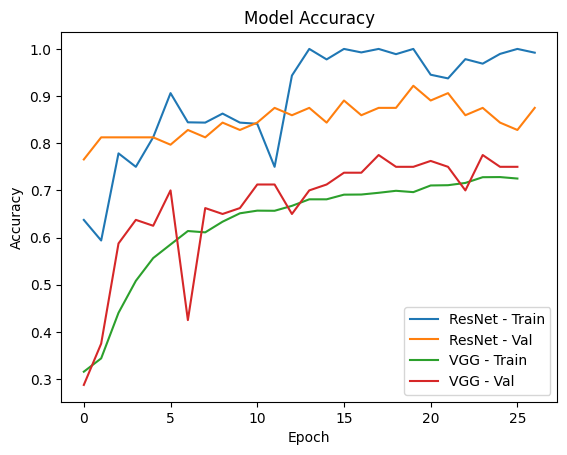

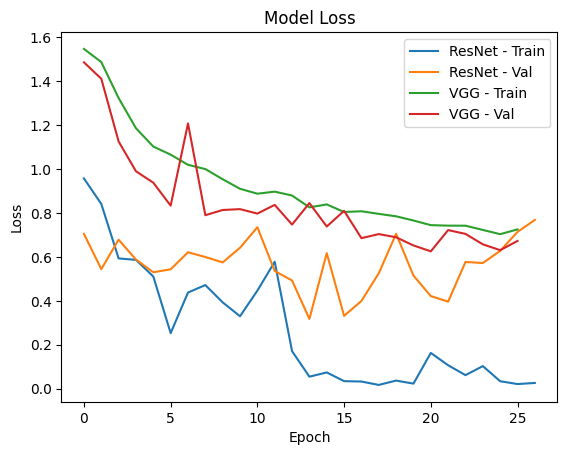

In [ ]:
import matplotlib.pyplot as plt

def combine_histories(*histories):
    combined = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    for h in histories:
        for key in combined:
            combined[key].extend(h.history.get(key, []))
    return combined

resnet_history = combine_histories(history1, history2, history3)


plt.plot(resnet_history['accuracy'], label='ResNet - Train')
plt.plot(resnet_history['val_accuracy'], label='ResNet - Val')
plt.plot(history.history['accuracy'], label='VGG - Train')
plt.plot(history.history['val_accuracy'], label='VGG - Val')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.plot(resnet_history['loss'], label='ResNet - Train')
plt.plot(resnet_history['val_loss'], label='ResNet - Val')
plt.plot(history.history['loss'], label='VGG - Train')
plt.plot(history.history['val_loss'], label='VGG - Val')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### <span style="color: #009E60;">**Compare Models:**

C:\Users\manih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step

 Report for VGG
              precision    recall  f1-score   support

       daisy       0.67      1.00      0.80        10
   dandelion       0.75      0.60      0.67        10
       roses       0.40      0.20      0.27        10
  sunflowers       0.75      0.90      0.82        10
      tulips       0.60      0.60      0.60        10

    accuracy                           0.66        50
   macro avg       0.63      0.66      0.63        50
weighted avg       0.63      0.66      0.63        50


 Confusion matrix for VGG


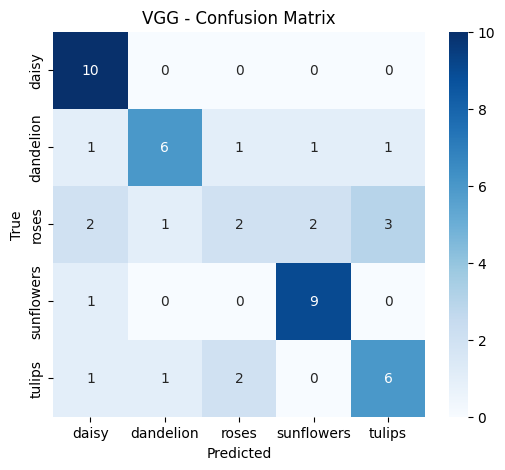

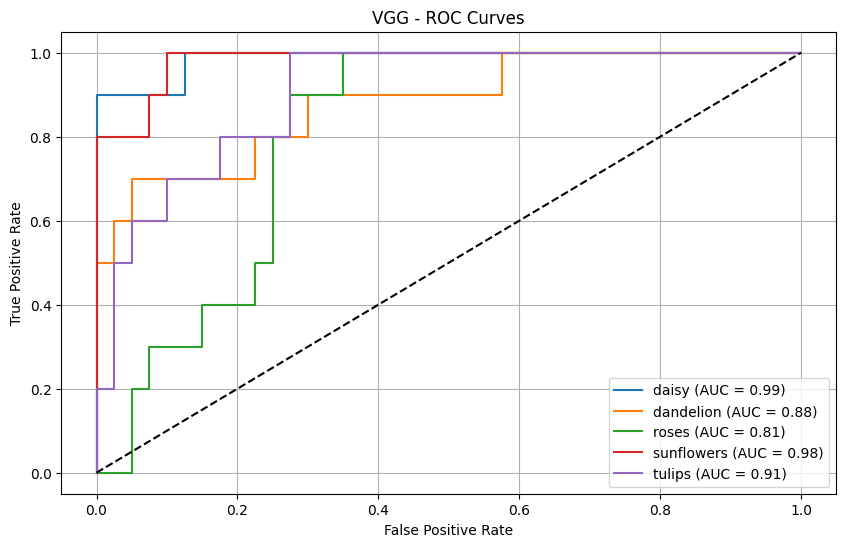

verage AUC for VGG: 0.9130
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step

 Report for ResNet-Stage 1
              precision    recall  f1-score   support

       daisy       0.75      0.60      0.67        10
   dandelion       0.33      0.50      0.40        10
       roses       0.00      0.00      0.00        10
  sunflowers       0.21      0.30      0.25        10
      tulips       0.31      0.40      0.35        10

    accuracy                           0.36        50
   macro avg       0.32      0.36      0.33        50
weighted avg       0.32      0.36      0.33        50


 Confusion matrix for ResNet-Stage 1


C:\Users\manih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\manih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\manih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

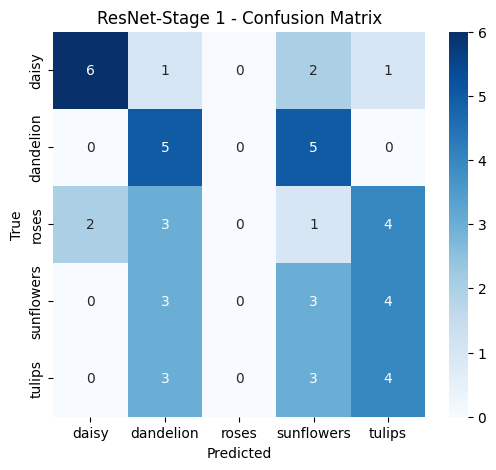

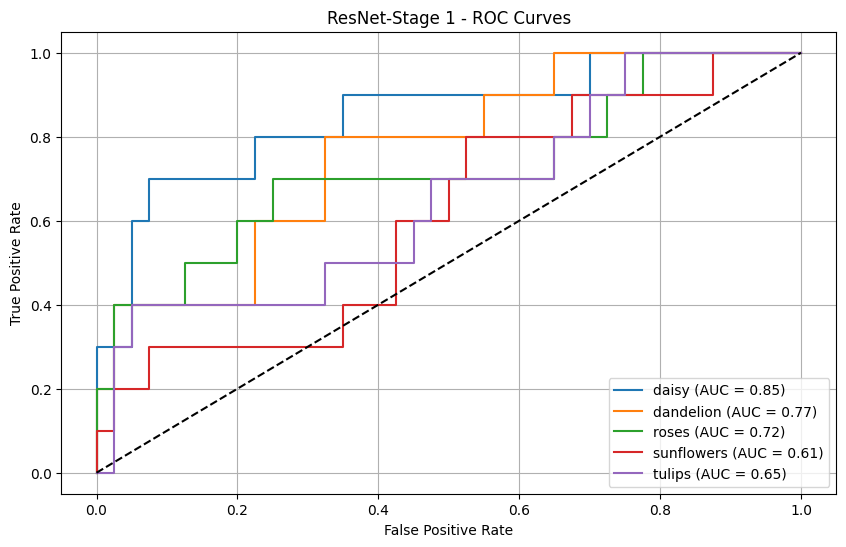

verage AUC for ResNet-Stage 1: 0.7205
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step

 Report for ResNet-Stage 2
              precision    recall  f1-score   support

       daisy       0.80      0.80      0.80        10
   dandelion       0.75      0.90      0.82        10
       roses       0.86      0.60      0.71        10
  sunflowers       1.00      0.90      0.95        10
      tulips       0.58      0.70      0.64        10

    accuracy                           0.78        50
   macro avg       0.80      0.78      0.78        50
weighted avg       0.80      0.78      0.78        50


 Confusion matrix for ResNet-Stage 2


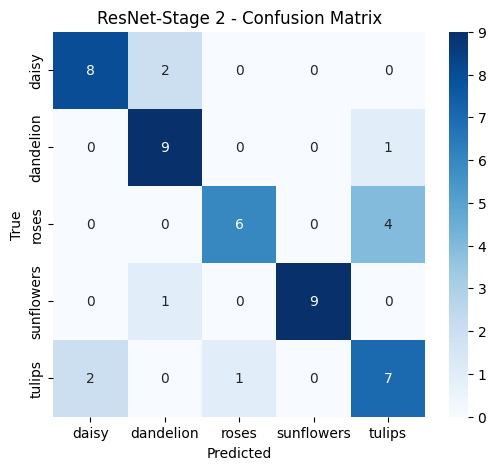

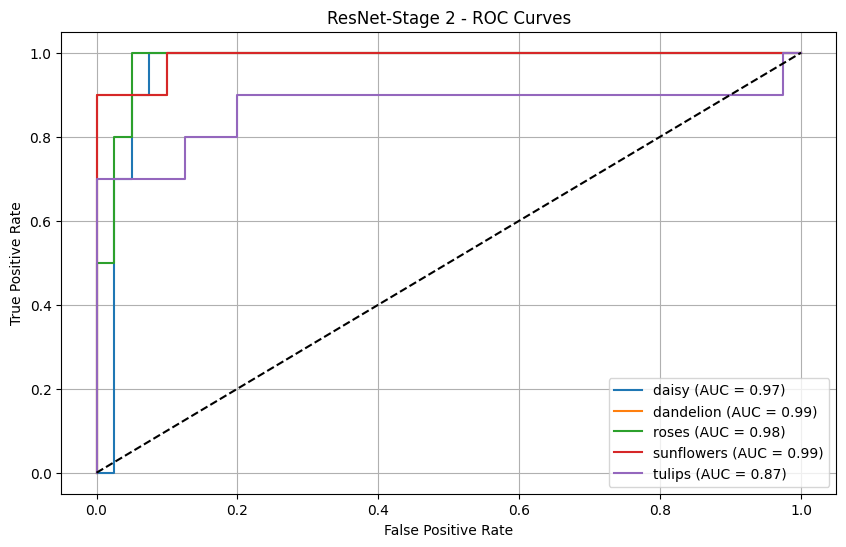

verage AUC for ResNet-Stage 2: 0.9595
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step

 Report for ResNet-Final
              precision    recall  f1-score   support

       daisy       0.80      0.80      0.80        10
   dandelion       0.75      0.90      0.82        10
       roses       0.86      0.60      0.71        10
  sunflowers       1.00      0.90      0.95        10
      tulips       0.58      0.70      0.64        10

    accuracy                           0.78        50
   macro avg       0.80      0.78      0.78        50
weighted avg       0.80      0.78      0.78        50


 Confusion matrix for ResNet-Final


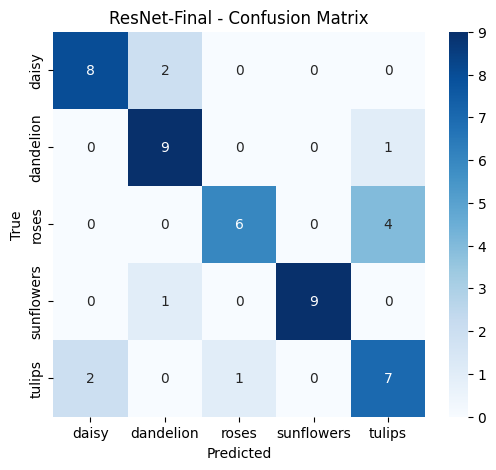

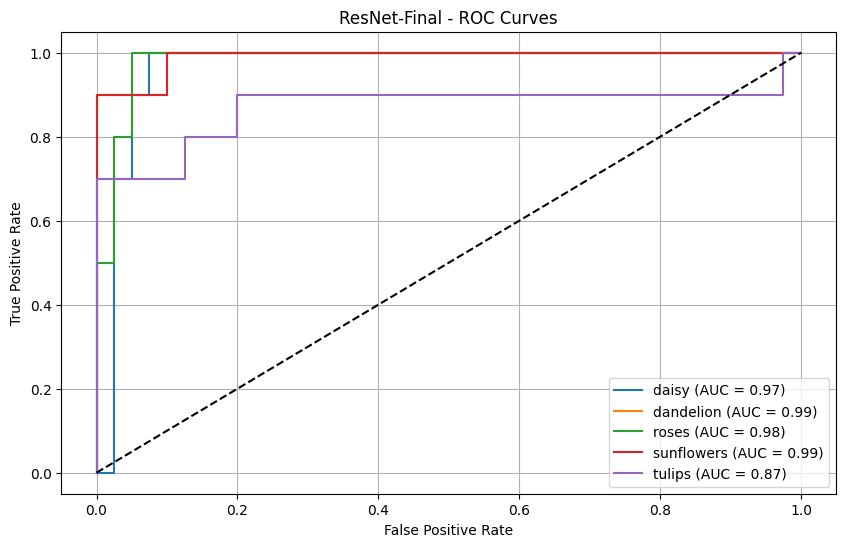

verage AUC for ResNet-Final: 0.9595


In [11]:


def evaluate_model(model, generator, model_name="Model"):
    y_prob = model.predict(generator)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())
    n_classes = len(class_names)

    print(f"\n Report for {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(f"\n Confusion matrix for {model_name}")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} - ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
    avg_auc = np.mean(list(roc_auc.values()))
    print(f"verage AUC for {model_name}: {avg_auc:.4f}")


evaluate_model(vgg_model, test_generator, model_name="VGG")
evaluate_model(resnet_stage1, test_generator, model_name="ResNet-Stage 1")
evaluate_model(resnet_stage3, test_generator, model_name="ResNet-Stage 2")
evaluate_model(resnet_stage3, test_generator, model_name="ResNet-Final")

